# Vehicle Detection
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)


In this project, your goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4), but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

Creating a great writeup:
---
A great writeup should include the rubric points as well as your description of how you addressed each point.  You should include a detailed description of the code used in each step (with line-number references and code snippets where necessary), and links to other supporting documents or external references.  You should include images in your writeup to demonstrate how your code works with examples.  

All that said, please be concise!  We're not looking for you to write a book here, just a brief description of how you passed each rubric point, and references to the relevant code :). 

You can submit your writeup in markdown or use another method and submit a pdf instead.

The Project
---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier.  These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.  

Some example images for testing your pipeline on single frames are located in the `test_images` folder.  To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include them in your writeup for the project by describing what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

**As an optional challenge** Once you have a working pipeline for vehicle detection, add in your lane-finding algorithm from the last project to do simultaneous lane-finding and vehicle detection!

**If you're feeling ambitious** (also totally optional though), don't stop there!  We encourage you to go out and take video of your own, and show us how you would implement this project on a new video!

## Data Preparation

The first step is to load the training data. The folowing code loads the filename of all the image files in the data folder, and classifies them if they are vehicles or not, depending on which folder they are located. Two examples of the images on the data set are provided.

Found 8792 image(s) of vehicles.
Found 8968 image(s) of not vehicles.


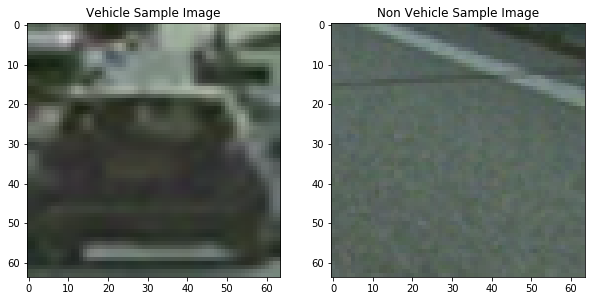

In [1]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import glob

images       = glob.glob('data/**/*.png', recursive = True)
vehicles     = []
not_vehicles = []

for image in images:
    if 'non-vehicles' in image:
        not_vehicles.append(image)
    else:
        vehicles.append(image)
        
print("Found {} image(s) of vehicles.".format(len(vehicles)))
print("Found {} image(s) of not vehicles.".format(len(not_vehicles)))

name_vehicle_sample     = random.choice(vehicles)
name_not_vehicle_sample = random.choice(not_vehicles)
vehicle_sample          = cv2.imread(name_vehicle_sample)
not_vehicle_sample      = cv2.imread(random.choice(not_vehicles))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('Vehicle Sample Image')
ax1.imshow(vehicle_sample)
ax2.set_title('Non Vehicle Sample Image')
ax2.imshow(not_vehicle_sample)

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

After loading the data and classify it, it's necessary to implement the function to extract the HOG features from every image on the data set. This done by the function **get_hog_features**, implemented as demonstrated on the Vehicle Detection Project Lesson. This function uses the **hog** function from the **skimage library**. A helper function that converts an image to a given color space using **opencv**, **convert_color** is also defined here. 

In [23]:
from skimage.feature import hog

# Converts an image to a given color space.
def convert_color(img, color_space = 'RGB'):
    result_image = img
    
    if color_space == 'HSV':
        result_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        result_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        result_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        result_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        result_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    return result_image

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis = False, feature_vec = True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations = orient, 
                                  pixels_per_cell = (pix_per_cell, pix_per_cell),
                                  cells_per_block = (cell_per_block, cell_per_block), 
                                  transform_sqrt = True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt = True, 
                       visualise=vis, feature_vector = feature_vec)
        return features

##### HOG Extraction Samples

/home/carlosj/Work/source/workspace/self-driving-car-course/tools/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:88: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)


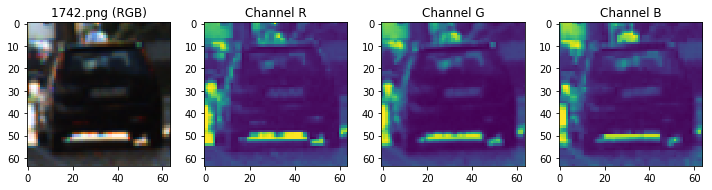

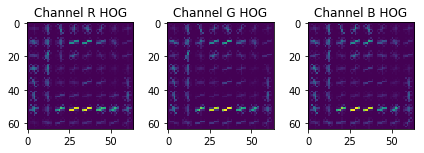

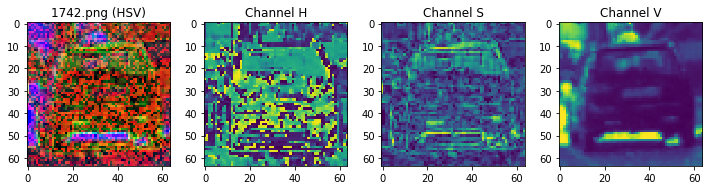

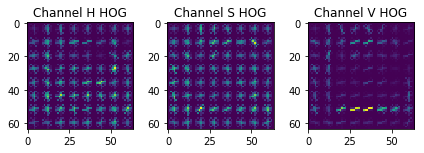

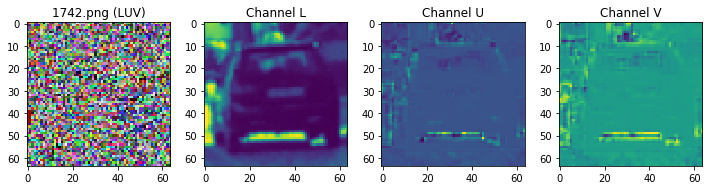

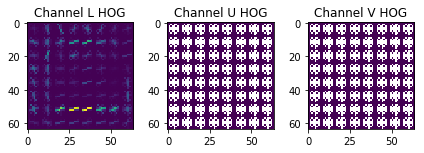

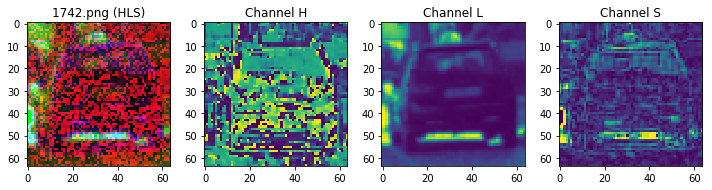

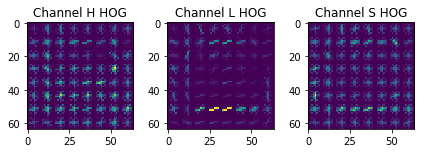

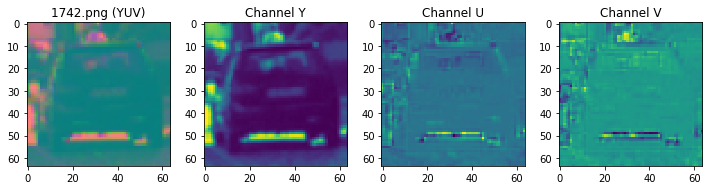

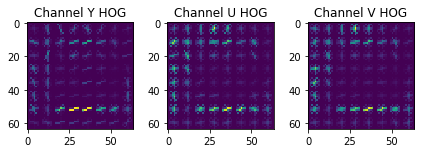

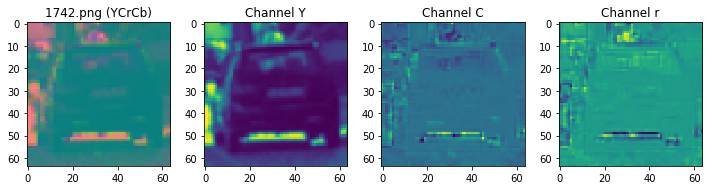

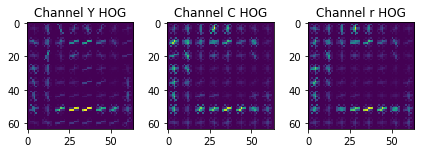

In [29]:
import ntpath

#Shows the HOG information for all the channels of an image.
def sample_hog_image(filename, color_space):
    orient           = 9  # HOG orientations
    pix_per_cell     = 8  # HOG pixels per cell
    cell_per_block   = 2  # HOG cells per block
    image            = mpimg.imread(filename)
    working_image    = convert_color(image, color_space)
    channel_hog_imgs = []
    
    for channel in range(image.shape[2]):
        features, hog_sample_img = get_hog_features(
            working_image[:,:,channel], 
            orient, 
            pix_per_cell, 
            cell_per_block, 
            True, 
            True)
        channel_hog_imgs.append(hog_sample_img)
    
    fig = plt.figure(figsize = (10,10))
    plt.subplot(141)
    plt.imshow(working_image)
    plt.title("{} ({})".format(ntpath.basename(filename), color_space))
    
    plt.subplot(142)
    plt.imshow(working_image[:,:,0])
    plt.title("Channel {}".format(color_space[0]))
    
    plt.subplot(143)
    plt.imshow(working_image[:,:,1])
    plt.title("Channel {}".format(color_space[1]))
    
    plt.subplot(144)
    plt.imshow(working_image[:,:,2])
    plt.title("Channel {}".format(color_space[2]))
    fig.tight_layout()
    
    fig = plt.figure(figsize = (6,6))
    
    plt.subplot(131)
    plt.imshow(channel_hog_imgs[0])
    plt.title("Channel {} HOG".format(color_space[0]))
    
    plt.subplot(132)
    plt.imshow(channel_hog_imgs[1])
    plt.title("Channel {} HOG".format(color_space[1]))
    
    plt.subplot(133)
    plt.imshow(channel_hog_imgs[2])
    plt.title("Channel {} HOG".format(color_space[2]))
    fig.tight_layout()

test_image_name   = random.choice(vehicles)
color_spaces_list = [ 'RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb' ]

for i in range(len(color_spaces_list)):
    sample_hog_image(test_image_name, color_spaces_list[i])

#### 2. Explain how you settled on your final choice of HOG parameters.

This are the HOG for every channel for every color space on a sample image from the vehicles set. In general, I can observate that YCrCb, YUV and seem to show a consistent representation of the HOG of the image across all the channels, which I think makes them useful for using all the channels during the HOG feature extraction. Other color spaces, such as HLS, LUV (which the only channel that got a representation was L) and HSV seem to have only one channel that can be useful for feature extraction. For my project, I decided to use YCrCb. The rest of the parameters came from experimenting with the accuracy of the linear SVC, and the detection accuracy on the test images.

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

Below are the functions I used to extract the features from the images on the data set. The function **extract_features** extracts the features from every image, combining the binned color features, color histogram features and HOG features, depending of the parameters passed to the function.

In [30]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = convert_color(image, color_space)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In the next section cell is the code used for training the classifier. I used a Linear SVC classifier, implemented on the sklearn library. The final choice of paramaters for the feature extraction are also here, and are as follows:

| Parameter       | Value            |
| -------------   |:-------------:   |
| color space     | YCrCb            |
| orientations    | 9                | 
| pixels per cell | 8                |
| cells per block | 2                |
| HOG channels    | All              |
| Spatial Size    | 16x16            |
| Histogram Bins  | 16               |

Next, the classifier is trained using the feature data extracted:

svc = LinearSVC()

svc.fit(X_train, y_train)

In [31]:
import time
from sklearn.svm             import LinearSVC
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split

color_space    = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient         = 9  # HOG orientations
pix_per_cell   = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel    = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size   = (32, 32) # Spatial binning dimensions
hist_bins      = 16    # Number of histogram bins
spatial_feat   = True # Spatial features on or off
hist_feat      = True # Histogram features on or off
hog_feat       = True # HOG features on or off

car_features = extract_features(vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(not_vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

features        = np.vstack((car_features, notcar_features)).astype(np.float64) 
scaler          = StandardScaler().fit(features)
scaled_features = scaler.transform(features)

# Define the labels vector
labels = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(scaled_features, labels, test_size=0.2, random_state=rand_state)

print("Training with color space: ", color_space)
print('Using:', orient, 'orientations', pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t1, 2), 'Seconds to train SVC.')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t3 = time.time()
print(round(t3-t2, 2), 'Seconds to predict a single sample.')

Training with color space:  YCrCb
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8412
18.65 Seconds to train SVC.
Test Accuracy of SVC =  0.9899
0.03 Seconds to predict a single sample.


### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

In my first implementation, the sliding window search was implemented using the first method described in the coursed, that consisted on extracting the features for every window, which turned out to be really slow given the processing and feature extraction that has to be done for every window image. Also, trying to do this processing for different scales on the target area (bottom half of the image) had a poor performance. To improve the performance of the algorithm, I used the HOG subsampling window search, that computes the HOG features only once for the region of interest.

The **CardDetector** class holds all the parameters to use in the detection, and the cache of frames that will help to smooth and make more accurate the object detection.

The window search is implemented in the **find_cars** function in the **CarDetector** class, and takes as parameters the boundaries of the search area, in X and Y. With this, the search area is extracted from the original image. Then, the HOG features for all the search area are calculated, which is one of the features that helps improve the performance of the first implementation of search windows. After this, the spatial and color features of the window are extracted, and then, based on the prediction of the classifier, the window is added to the list of boxes that will be used to build the heat map.

In [101]:
from collections import deque

FRAME_CACHE_LIMIT = 10

class CarDetector:
    def __init__(self, color_space, orient, pix_per_cell, cell_per_block,
                 hog_channel, spatial_size, hist_bins, spatial_feat, hist_feat,
                 hog_feat, heat_threshold, 
                 X_scaler, clf, max_queue_len):

        self.color_space    = color_space
        self.orient         = orient
        self.pix_per_cell   = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel    = hog_channel
        self.spatial_size   = spatial_size
        self.hist_bins      = hist_bins
        self.spatial_feat   = spatial_feat
        self.hist_feat      = hist_feat
        self.hog_feat       = hog_feat
        self.heat_threshold = heat_threshold
        self.X_scaler       = X_scaler
        self.clf            = clf
        self.recent_xfitted = deque(maxlen = FRAME_CACHE_LIMIT)
    
    # Define a single function that can extract features using hog sub-sampling and make predictions
    def find_cars(self, img, x_start_stop = [None, None], y_start_stop = [None, None], scale = 1):
        if x_start_stop[0] is None:
            x_start_stop[0] = 0
        if x_start_stop[1] is None:
            x_start_stop[1] = img.shape[1]
        if y_start_stop[0] is None:
            y_start_stop[0] = 0
        if y_start_stop[1] is None:
            y_start_stop[1] = img.shape[0]

        draw_img        = np.copy(img)
        img             = img.astype(np.float32) / 255
        img_tosearch    = img[y_start_stop[0] : y_start_stop[1], x_start_stop[0] : x_start_stop[1] , :]
        ctrans_tosearch = convert_color(img_tosearch, color_space = self.color_space)
        
        if scale != 1:
            image_shape     = ctrans_tosearch.shape
            resize_pt       = (np.int(image_shape[1] / scale), np.int(image_shape[0] / scale))
            ctrans_tosearch = cv2.resize(ctrans_tosearch, resize_pt)

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks        = (ch1.shape[1] // self.pix_per_cell) - 1
        nyblocks        = (ch1.shape[0] // self.pix_per_cell) - 1 
        nfeat_per_block = self.orient * self.cell_per_block ** 2
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // self.pix_per_cell) - 1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)

        boxes = []

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb * cells_per_step
                xpos = xb * cells_per_step

                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos * self.pix_per_cell
                ytop  = ypos * self.pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop : ytop + window, xleft : xleft + window], (64, 64))

                # Get color features
                spatial_features = bin_spatial(subimg, size = self.spatial_size)
                hist_features    = color_hist(subimg, nbins = hist_bins)

                # Scale features and make a prediction
                test_features   = self.X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                test_prediction = self.clf.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft  * scale)
                    ytop_draw = np.int(ytop   * scale)
                    win_draw  = np.int(window * scale)
                    x_start   = xbox_left + x_start_stop[0]
                    y_start   = ytop_draw + y_start_stop[0];

                    top_left_pt     = (x_start, y_start)
                    bottom_right_pt = (x_start + win_draw , y_start + win_draw)

                    boxes.append([top_left_pt, bottom_right_pt])

        return boxes
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

# Adds a list of frames 
def add_frames(frames):
    frames_stack = np.array(frames)
    return np.sum(frames_stack, 0)
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img    

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

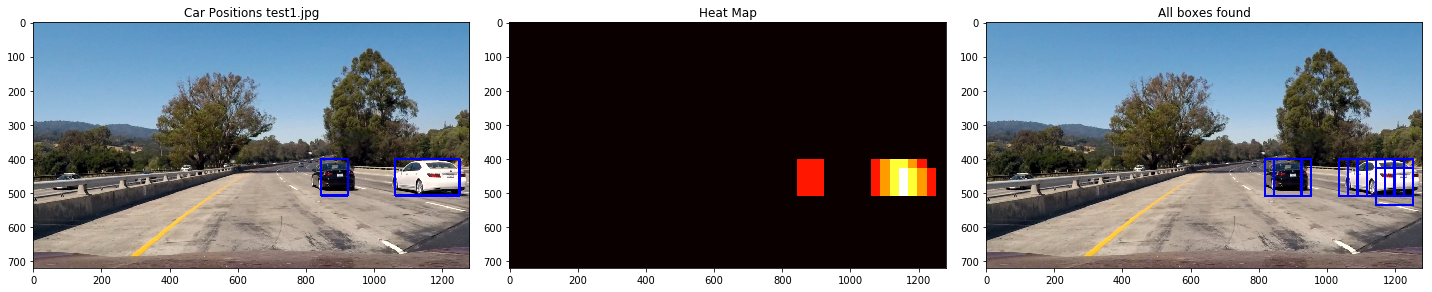

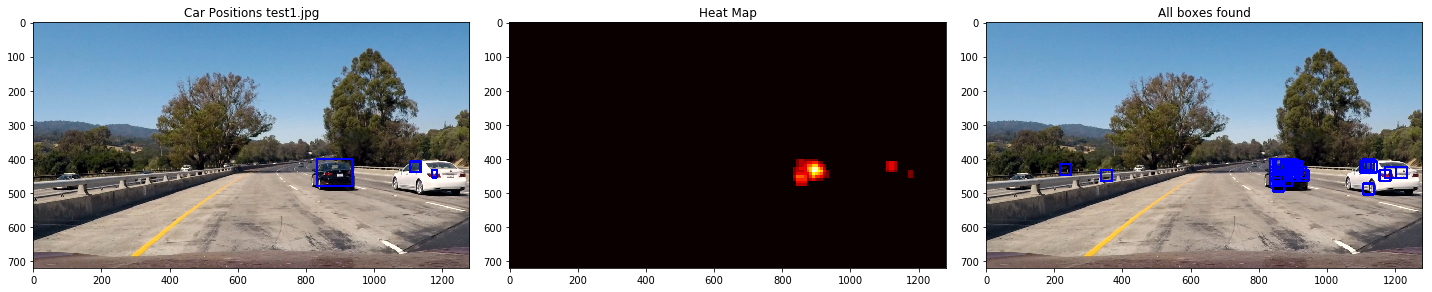

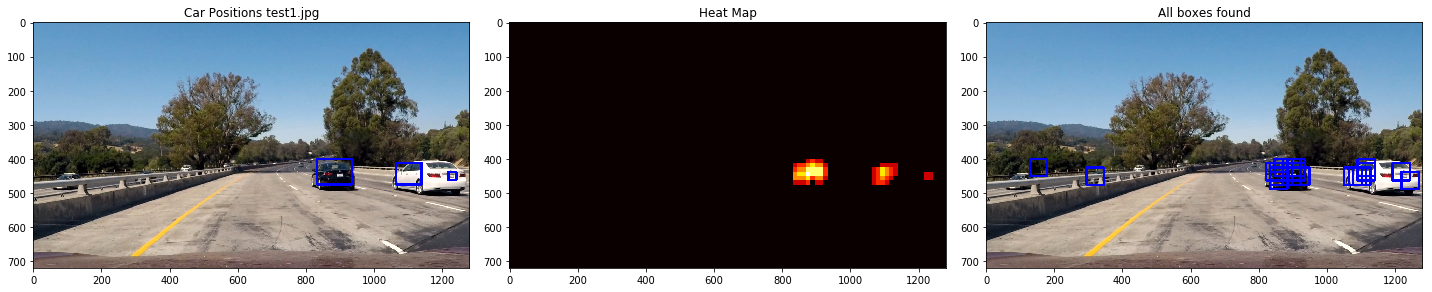

In [110]:
from scipy.ndimage.measurements import label

color_space    = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient         = 9 # HOG orientations
pix_per_cell   = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel    = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size   = (32, 32) # Spatial binning dimensions
hist_bins      = 16    # Number of histogram bins
spatial_feat   = True # Spatial features on or off
hist_feat      = True # Histogram features on or off
hog_feat       = True # HOG features on or off

detector = CarDetector(color_space=color_space, 
            orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block,
            hog_channel = hog_channel, spatial_size = spatial_size,
            hist_bins = hist_bins, spatial_feat = spatial_feat, hist_feat = hist_feat,
            hog_feat = hog_feat, heat_threshold = 30, X_scaler = scaler,
            clf = svc, max_queue_len = 25)

def single_scale_pipeline(image_name, scale = 1.5, x_start_stop = [None, None], y_start_stop = [None, None]):
    filename     = ntpath.basename(image_name)
    image        = mpimg.imread(image_name)
    #scale        = 1.5

    #get boxes
    #boxes = find_cars(
    #    image, svc, scaler, x_start_stop, y_start_stop, scale, orient, 
    #    pix_per_cell, cell_per_block, spatial_size, hist_bins)
    boxes = detector.find_cars(image, x_start_stop, y_start_stop, scale)
    #boxes = find_cars(image, y_start_stop, scale, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    # Add heat to each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels   = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    boxes_im = draw_boxes(np.copy(image), boxes)

    fig = plt.figure(figsize = (20,20))

    plt.subplot(133)
    plt.imshow(boxes_im)
    plt.title('All boxes found')
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(131)
    plt.imshow(draw_img)
    plt.title('Car Positions {}'.format(filename))
    fig.tight_layout()

x_limits = [None, None]
y_limits = [400, 670]
scale    = 1.7
single_scale_pipeline('test_images/test1.jpg', scale, x_limits, y_limits)
x_limits = [None, None]
y_limits = [400, 600]
scale    = 0.5
single_scale_pipeline('test_images/test1.jpg', scale, x_limits, y_limits)
x_limits = [None, None]
y_limits = [400, 580]
scale    = 0.8
single_scale_pipeline('test_images/test1.jpg', scale, x_limits, y_limits)

This are images of the detection made by the function **find_cars**, that show the execution of the function on the sets of search areas and scales, that will be also used on the video. This search areas and scales are:

| Y Limits      | X Limits         | Scale           |
| ------------- |:-------------:   | :-------------: |
| [490, 580]    | Whole Width      | 0.8             |
| [500, 600]    | [None, 720]      | 0.5             |
| [520, 670]    | Whole Width      | 1.7             |


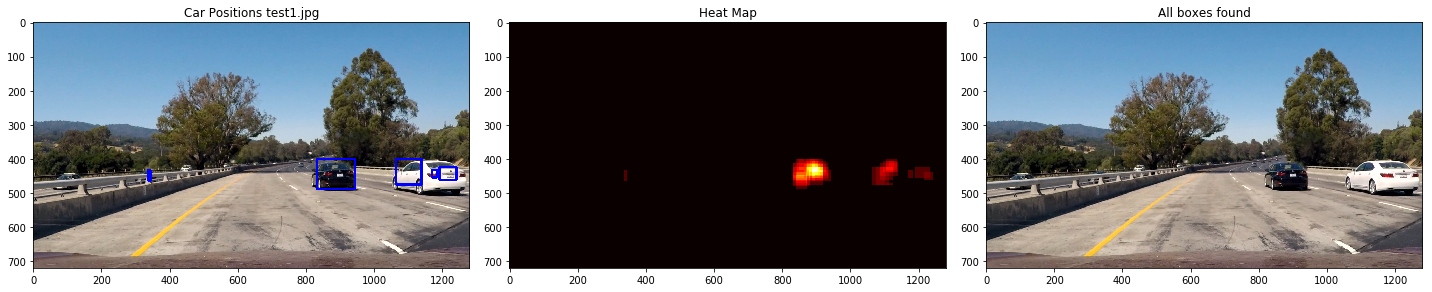

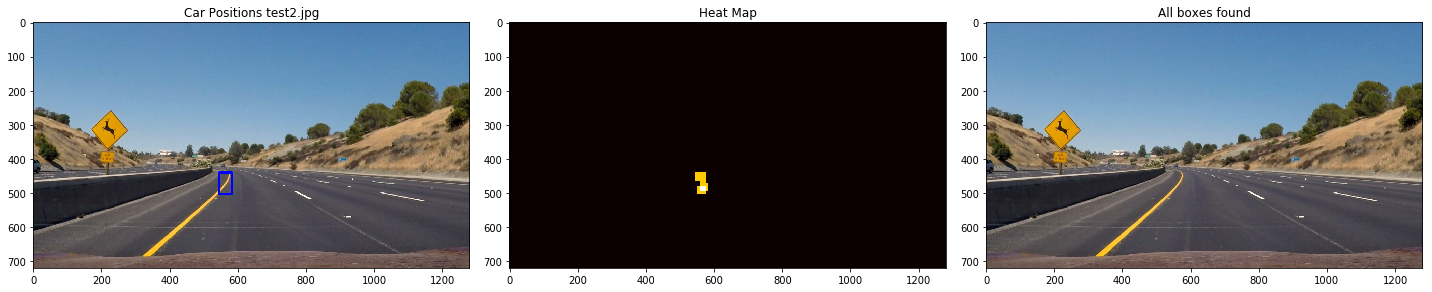

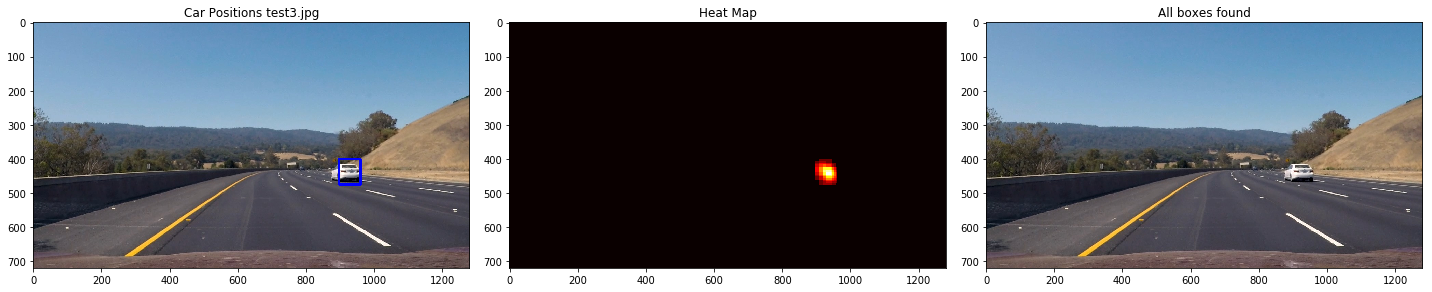

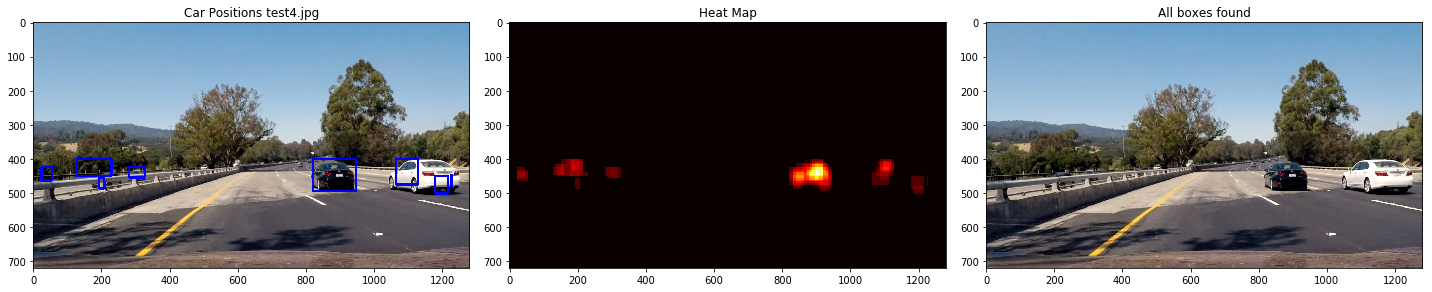

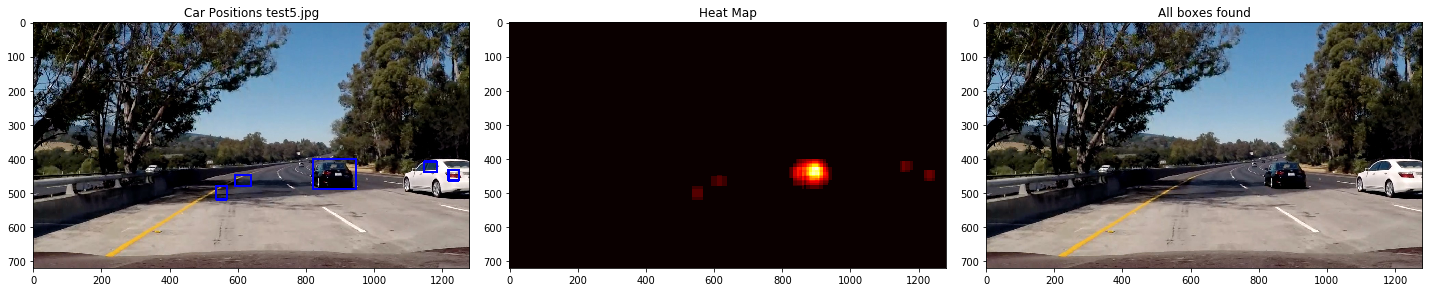

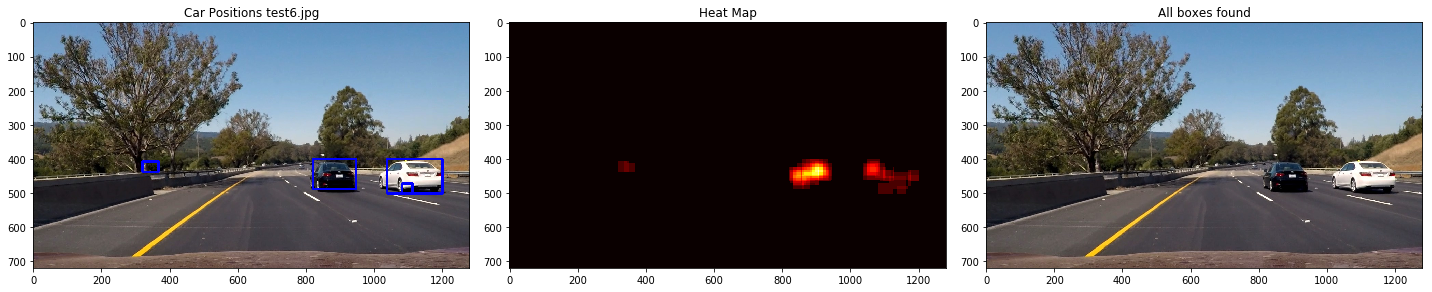

In [113]:
def combined_scales_pipeline(image_name):
    filename = ntpath.basename(image_name)
    image    = mpimg.imread(image_name)
    heat     = np.zeros_like(image[:,:,0]).astype(np.float)
    
    boxes = detector.find_cars(image, x_start_stop = [None, None], y_start_stop = [400, 580], scale = 0.8)
    heat  = add_heat(heat, boxes)
    boxes = detector.find_cars(image, x_start_stop = [None, None], y_start_stop = [400, 600], scale = 0.5)
    heat  = add_heat(heat, boxes)
    boxes = detector.find_cars(image, x_start_stop = [None, None], y_start_stop = [500, 670], scale = 1.7)
    heat  = add_heat(heat, boxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    labels   = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    boxes_im = draw_boxes(np.copy(image), boxes)
    
    fig = plt.figure(figsize = (20,20))

    plt.subplot(133)
    plt.imshow(boxes_im)
    plt.title('All boxes found')
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(131)
    plt.imshow(draw_img)
    plt.title('Car Positions {}'.format(filename))
    fig.tight_layout()

test_images = glob.glob('test_images/*.jpg')
test_images.sort()

for idx, fname in enumerate(test_images):
    combined_scales_pipeline(fname)